In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/sample_submission.csv
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/train.csv
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/test.csv
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/cf8d949f9-2.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/41e824cbe-3.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/687be6419-4.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/081199ea2-12.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/924cc5438-4.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/b1ed265ef-11.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/images/test/9daaa4e8f-1.jpg
/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/images/i

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
import logging
import re


warnings.simplefilter(action='ignore', category=FutureWarning)

# Налаштування логування
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# 1️⃣ Завантаження даних
DATASET_PATH = "/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02"
IMAGE_PATH = f"{DATASET_PATH}/images/images"

train_df = pd.read_csv("/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/train.csv")
test_df = pd.read_csv("/kaggle/input/deep-learning-for-computer-vision-and-nlp-2025-02/test.csv")

print(train_df.head())

print("Дані завантажено!")

print("Колонки в train_df:", train_df.columns.tolist())
print("Колонки в test_df:", test_df.columns.tolist())

       PetID                                        Description  AdoptionSpeed
0  d3b4f29f8  Mayleen and Flo are two lovely adorable sister...              2
1  e9dc82251  A total of 5 beautiful Tabbys available for ad...              2
2  8111f6d4a  Two-and-a-half month old girl. Very manja and ...              2
3  693a90fda  Neil is a healthy and active ~2-month-old fema...              2
4  9d08c85ef  Gray kitten available for adoption in sungai p...              2
Дані завантажено!
Колонки в train_df: ['PetID', 'Description', 'AdoptionSpeed']
Колонки в test_df: ['PetID', 'Description']


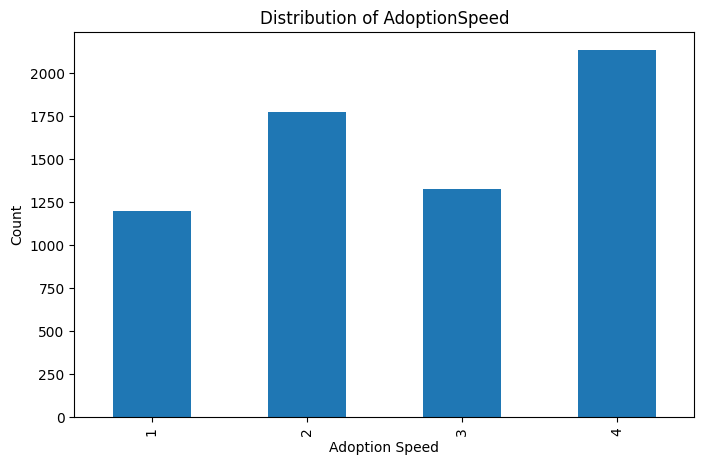

Графік AdoptionSpeed побудовано!


In [4]:
# 2️⃣ Візуалізація розподілу AdoptionSpeed
plt.figure(figsize=(8, 5))
train_df["AdoptionSpeed"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Adoption Speed")
plt.ylabel("Count")
plt.title("Distribution of AdoptionSpeed")
plt.show()
print("Графік AdoptionSpeed побудовано!")

In [5]:
# 3️⃣ Текстова обробка
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

train_df["CleanedDescription"] = train_df["Description"].fillna(" ").apply(preprocess_text)
test_df["CleanedDescription"] = test_df["Description"].fillna(" ").apply(preprocess_text)
print("Текстові дані очищено!")

Текстові дані очищено!


In [6]:
# 4️⃣ TF-IDF Векторизація (виправлено)
vectorizer = CountVectorizer(max_features=5000)
all_descriptions = pd.concat([train_df["CleanedDescription"], test_df["CleanedDescription"]], axis=0)  # 🔹 Гарантуємо однаковий словник
vectorizer.fit(all_descriptions)  # Навчаємо на всіх доступних даних

X_train_tfidf = vectorizer.transform(train_df["CleanedDescription"])
X_test_tfidf = vectorizer.transform(test_df["CleanedDescription"])

print("✅ TF-IDF векторизація завершена! (Однаковий словник для train і test)")

✅ TF-IDF векторизація завершена! (Однаковий словник для train і test)


In [7]:
# 5️⃣ Витягнення ознак із зображень

resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

def extract_batch_features(pet_ids, image_dir, batch_size=32):
    features_dict = {}
    batch_images, batch_pet_ids = [], []

    for pet_id in tqdm(pet_ids):
        img_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.startswith(pet_id)]
        
        for img_path in img_paths:
            try:
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                batch_images.append(img_array)
                batch_pet_ids.append(pet_id)

                # обробляємо batch
                if len(batch_images) == batch_size:
                    batch_array = preprocess_input(np.array(batch_images))
                    batch_feats = resnet_model.predict(batch_array, verbose=0)
                    for pid, feat in zip(batch_pet_ids, batch_feats):
                        features_dict.setdefault(pid, []).append(feat)
                    batch_images, batch_pet_ids = [], []
            except Exception as e:
                logging.warning(f"Error loading {img_path}: {e}")

    # залишковий batch
    if batch_images:
        batch_array = preprocess_input(np.array(batch_images))
        batch_feats = resnet_model.predict(batch_array, verbose=0)
        for pid, feat in zip(batch_pet_ids, batch_feats):
            features_dict.setdefault(pid, []).append(feat)

    # усереднення ознак
    averaged_features = {
        pet_id: np.mean(feats, axis=0) if feats else np.zeros(2048)
        for pet_id, feats in features_dict.items()
    }

    return averaged_features

# 🔸 Швидке витягнення ознак
train_image_features = extract_batch_features(train_df["PetID"].values, IMAGE_PATH + "/train")
test_image_features = extract_batch_features(test_df["PetID"].values, IMAGE_PATH + "/test")

# Створення датафреймів
train_image_features_df = pd.DataFrame.from_dict(train_image_features, orient="index").reset_index()
train_image_features_df.columns = ["PetID"] + [f"img_feat_{i}" for i in range(2048)]
train_df = train_df.merge(train_image_features_df, on="PetID", how="left").fillna(0)

test_image_features_df = pd.DataFrame.from_dict(test_image_features, orient="index").reset_index()
test_image_features_df.columns = ["PetID"] + [f"img_feat_{i}" for i in range(2048)]
test_df = test_df.merge(test_image_features_df, on="PetID", how="left").fillna(0)

# Виділення ознак зображень для моделі
X_train_images = train_df.iloc[:, -2048:].values
X_test_images = test_df.iloc[:, -2048:].values

print("✅ Ознаки зображень швидко отримано і для train, і для test!")

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_train_images shape:", X_train_images.shape)
print("train_df shape:", train_df.shape)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 1891/1891 [02:07<00:00, 14.89it/s]


✅ Ознаки зображень швидко отримано і для train, і для test!
X_train_tfidf shape: (6431, 5000)
X_train_images shape: (6431, 2048)
train_df shape: (6431, 2052)


In [8]:
# 6️⃣ Об'єднання ознак (текст + зображення)

X = np.hstack((X_train_tfidf.toarray(), X_train_images))
y = train_df["AdoptionSpeed"].values

# Поділ на тренувальний та валідаційний набори
X_train_combined, X_val_combined, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Також створюємо комбіновані ознаки для тестових даних
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_images))

# 6️⃣ Об'єднання ознак TF-IDF та зображень
X_train_combined = np.hstack((X_train_tfidf.toarray(), train_df.iloc[:, -2048:].values))
X_test_combined = np.hstack((X_test_tfidf.toarray(), test_df.iloc[:, -2048:].values))

print("X_train_combined shape:", X_train_combined.shape)  # Має бути (6431, 7048)
print("X_test_combined shape:", X_test_combined.shape)
print("✅ Ознаки тексту та зображень успішно об'єднані!")

X_train_combined shape: (6431, 7048)
X_test_combined shape: (1891, 7048)
✅ Ознаки тексту та зображень успішно об'єднані!


In [9]:
# 7️⃣ Розбиття, масштабування та балансування (SMOTE)

# Розбиття на train і validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_combined, train_df["AdoptionSpeed"], test_size=0.2, random_state=42
)

# Масштабування ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_combined)

# Балансування класів (SMOTE)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train - 1)

# Коригуємо мітки для валідації
y_val = y_val - 1

print("✅ Розбиття, масштабування та балансування класів завершено!")


✅ Розбиття, масштабування та балансування класів завершено!


In [10]:
# 8️⃣ Навчання моделі XGBoost з найкращими параметрами

best_params = {
    'n_estimators': 455,
    'max_depth': 5,
    'learning_rate': 0.03712089951043461,
    'subsample': 0.8735111012570632,
    'colsample_bytree': 0.7964814950330481,
    'gamma': 1.488094612722748,
    'min_child_weight': 7,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Навчання фінальної моделі
final_model = XGBClassifier(**best_params)
final_model.fit(X_train_smote, y_train_smote)

# Передбачення на валідації
final_preds = final_model.predict(X_val_scaled)
final_accuracy = accuracy_score(y_val, final_preds)
final_f1 = classification_report(y_val, final_preds, output_dict=True)["weighted avg"]["f1-score"]

print(f'📊 Accuracy на валідації: {final_accuracy:.4f}')
print(f'📊 F1-score (зважене) на валідації: {final_f1:.4f}')


📊 Accuracy на валідації: 0.4988
📊 F1-score (зважене) на валідації: 0.4882


In [11]:
# 9️⃣ Передбачення на тестових даних та створення submission-файлу

submission_preds = final_model.predict(X_test_scaled) + 1  # Відновлюємо оригінальний діапазон міток
submission_df = pd.DataFrame({'PetID': test_df['PetID'], 'AdoptionSpeed': submission_preds})
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

print("✅ Сабміт-файл створено!")

# Перевірка submission-файлу
submission_df.head()

if os.path.exists("/kaggle/working/submission.csv"):
    print("✅ Файл submission.csv успішно створено!")
else:
    print("❌ Файл submission.csv не знайдено!")

✅ Сабміт-файл створено!
✅ Файл submission.csv успішно створено!
